In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append('../src')

from data_collection import FinancialDataCollector
from data_processing import FinancialDataProcessor
from config import SECTOR_MAPPING
from visualization_utils import VisualizationUtils

In [3]:
# Load data
collector = FinancialDataCollector()
stock_data = collector.load_stock_data()
processor = FinancialDataProcessor(stock_data)

Data loaded from data\raw\stock_data.pkl


In [4]:
# Setup
viz_utils = VisualizationUtils()
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

Plot saved to static/images\seaborn_correlation_heatmap.png


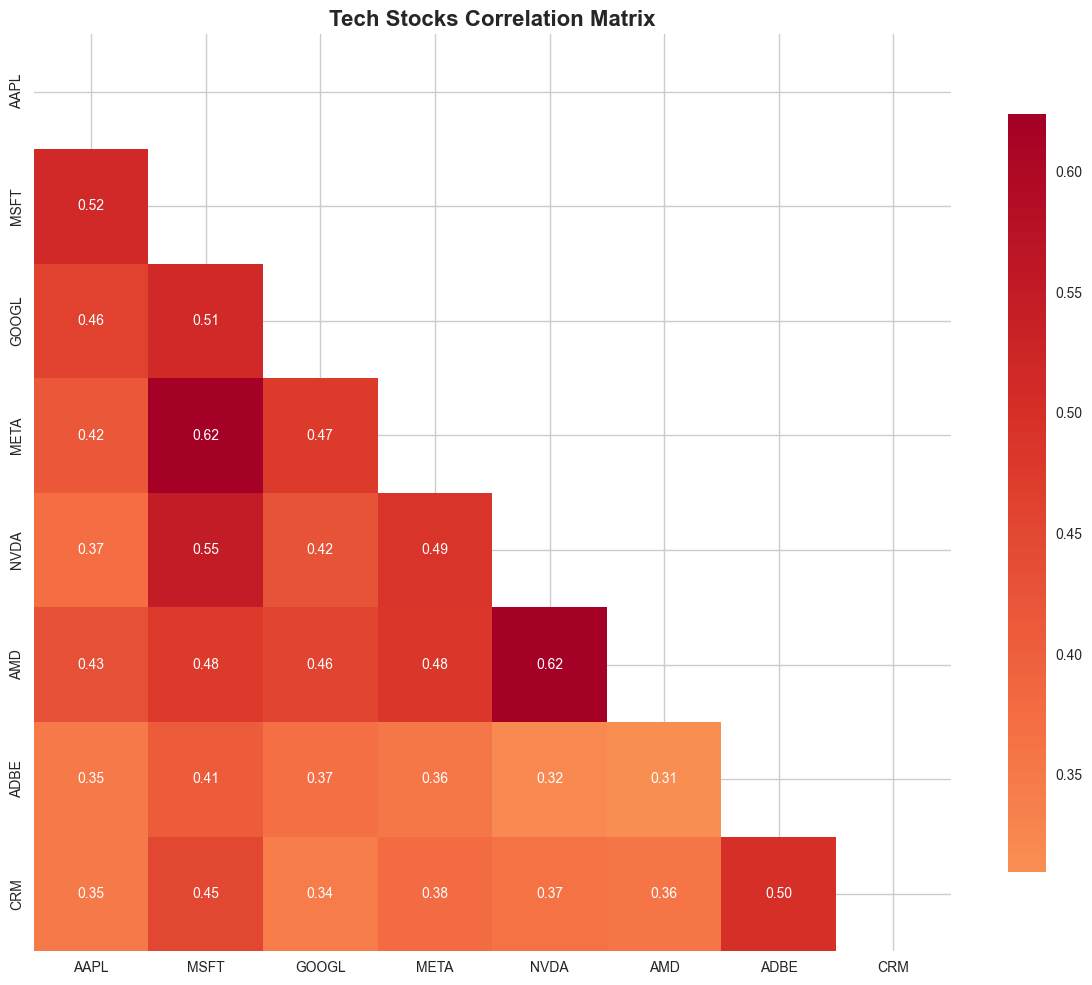

In [5]:
# Plot-1. Correlation Heatmap
def create_correlation_heatmap():
    tech_stocks = ['AAPL', 'MSFT', 'GOOGL', 'META', 'NVDA', 'AMD', 'ADBE', 'CRM']       # Get correlation matrix
    correlation_matrix = processor.calculate_correlation_matrix(tech_stocks)
    
    plt.figure(figsize=(12, 10))
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))                        # Create heatmap
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdYlBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={'shrink': 0.8})
    
    plt.title('Tech Stocks Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    viz_utils.save_plot(plt.gcf(), 'seaborn_correlation_heatmap.png')
    plt.show()

create_correlation_heatmap()

Plot saved to static/images\seaborn_sector_boxplot.png


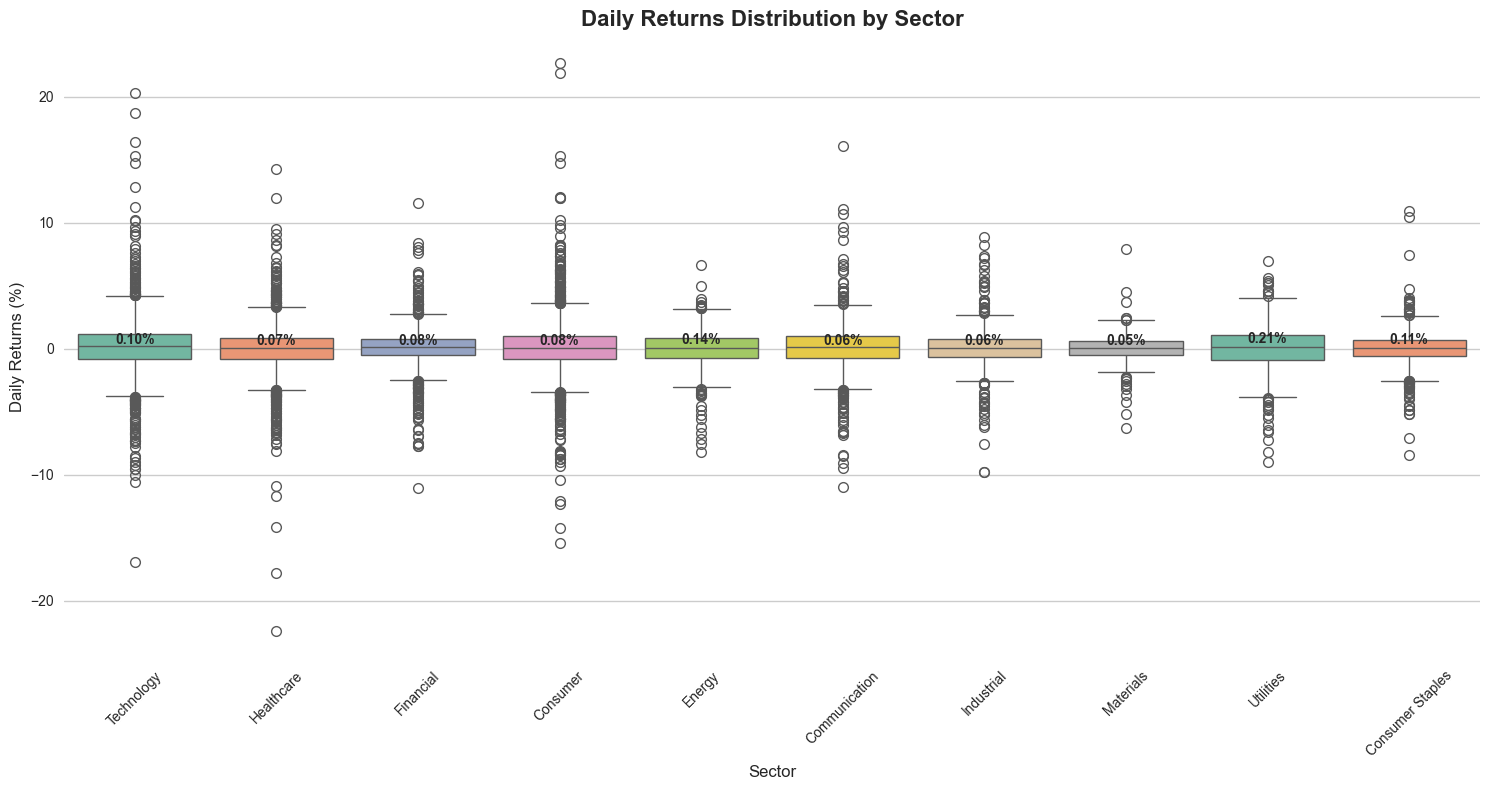

In [6]:
# Plot-2. Sector Performance Box Plot
def create_sector_boxplot():
    
    sector_returns_data = []            # Prepare sector returns data
    
    for sector, tickers in SECTOR_MAPPING.items():
        for ticker in tickers[:5]:                      # Limit to 5 stocks per sector
            if ticker in stock_data:
                returns = stock_data[ticker]['prices']['Returns'].dropna() * 100
                for ret in returns:
                    sector_returns_data.append({'Sector': sector, 'Daily_Return': ret})
    
    sector_df = pd.DataFrame(sector_returns_data)
    
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=sector_df, x='Sector', y='Daily_Return', hue='Sector', palette='Set2')
    plt.title('Daily Returns Distribution by Sector', fontsize=16, fontweight='bold')
    plt.xlabel('Sector', fontsize=12)
    plt.ylabel('Daily Returns (%)', fontsize=12)
    plt.xticks(rotation=45)
    
    medians = sector_df.groupby('Sector')['Daily_Return'].median()          # Add median line
    for i, sector in enumerate(medians.index):
        plt.text(i, medians[sector], f'{medians[sector]:.2f}%', 
                ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    viz_utils.save_plot(plt.gcf(), 'seaborn_sector_boxplot.png')
    plt.show()

create_sector_boxplot()

Plot saved to static/images\seaborn_risk_return.png


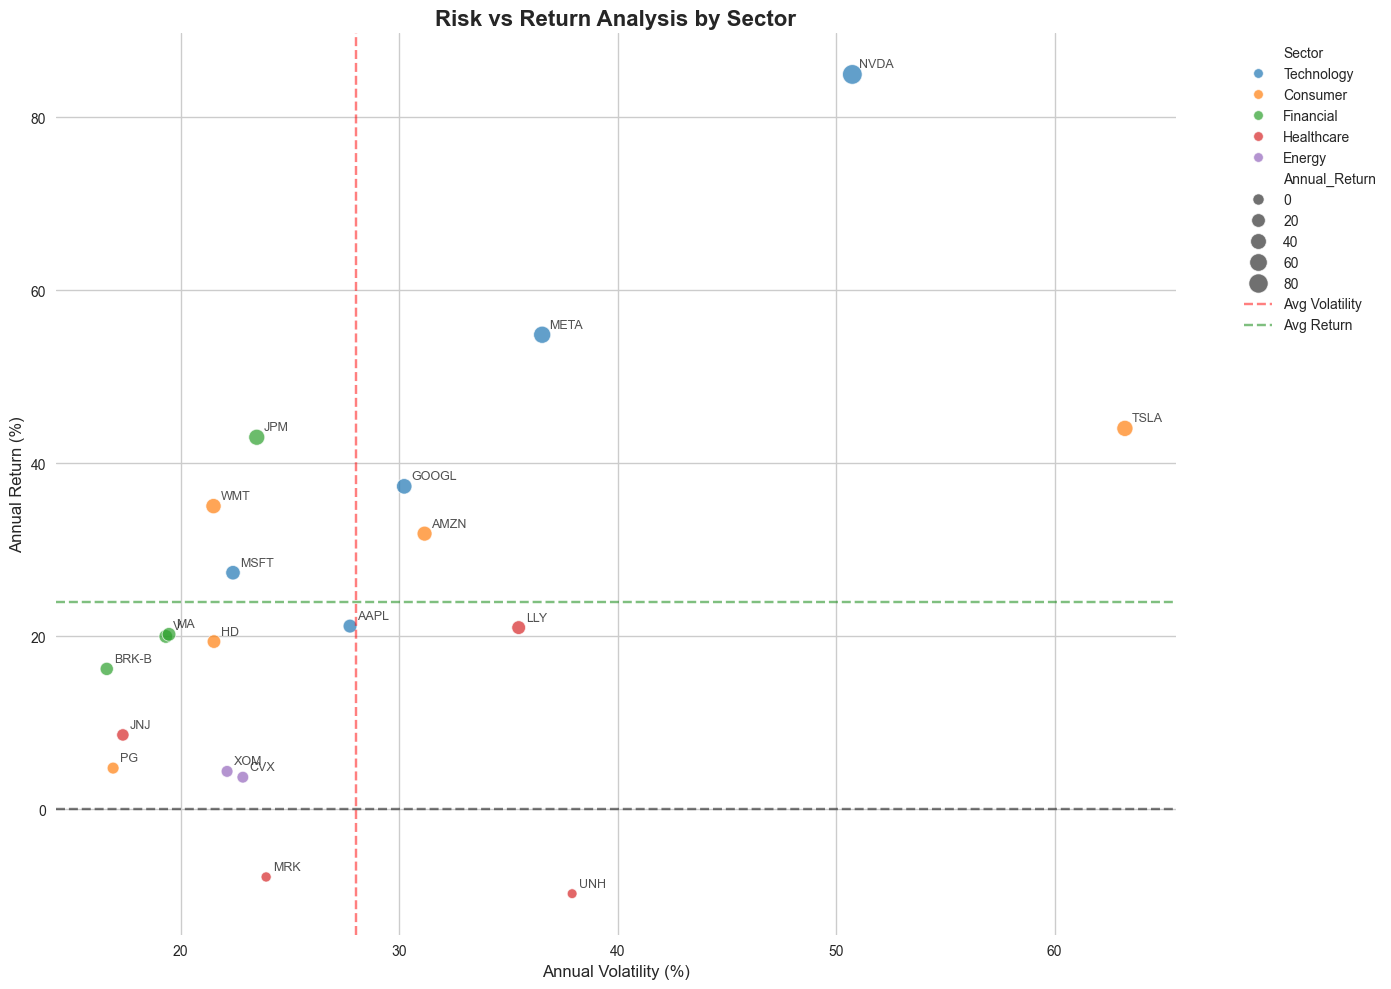

In [7]:
# Plot-3: Risk-Return Scatter Plot
def create_risk_return_plot():
    risk_return_data = []
    
    for ticker in list(stock_data.keys())[:20]:         # Top 20 stocks
        returns = stock_data[ticker]['prices']['Returns'].dropna()
        annual_return = returns.mean() * 252 * 100
        annual_volatility = returns.std() * np.sqrt(252) * 100
        
        sector = 'Other'                                # Get sector
        for sect, tickers in SECTOR_MAPPING.items():
            if ticker in tickers:
                sector = sect
                break
        
        risk_return_data.append({
            'Ticker': ticker,
            'Annual_Return': annual_return,
            'Annual_Volatility': annual_volatility,
            'Sector': sector
        })
    
    risk_return_df = pd.DataFrame(risk_return_data)
    
    plt.figure(figsize=(14, 10))
    
    sns.scatterplot(data=risk_return_df,                # Create scatter plot
                    x='Annual_Volatility', 
                    y='Annual_Return',
                    hue='Sector',
                    size='Annual_Return',
                    sizes=(50, 200),
                    alpha=0.7)
    
    for idx, row in risk_return_df.iterrows():          # Add stock labels
        plt.annotate(row['Ticker'], 
                    (row['Annual_Volatility'], row['Annual_Return']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    plt.title('Risk vs Return Analysis by Sector', fontsize=16, fontweight='bold')
    plt.xlabel('Annual Volatility (%)', fontsize=12)
    plt.ylabel('Annual Return (%)', fontsize=12)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=risk_return_df['Annual_Volatility'].mean(), color='red', 
                linestyle='--', alpha=0.5, label='Avg Volatility')
    plt.axhline(y=risk_return_df['Annual_Return'].mean(), color='green', 
                linestyle='--', alpha=0.5, label='Avg Return')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    viz_utils.save_plot(plt.gcf(), 'seaborn_risk_return.png')
    plt.show()

create_risk_return_plot()

Plot saved to static/images\seaborn_tech_pairplot.png


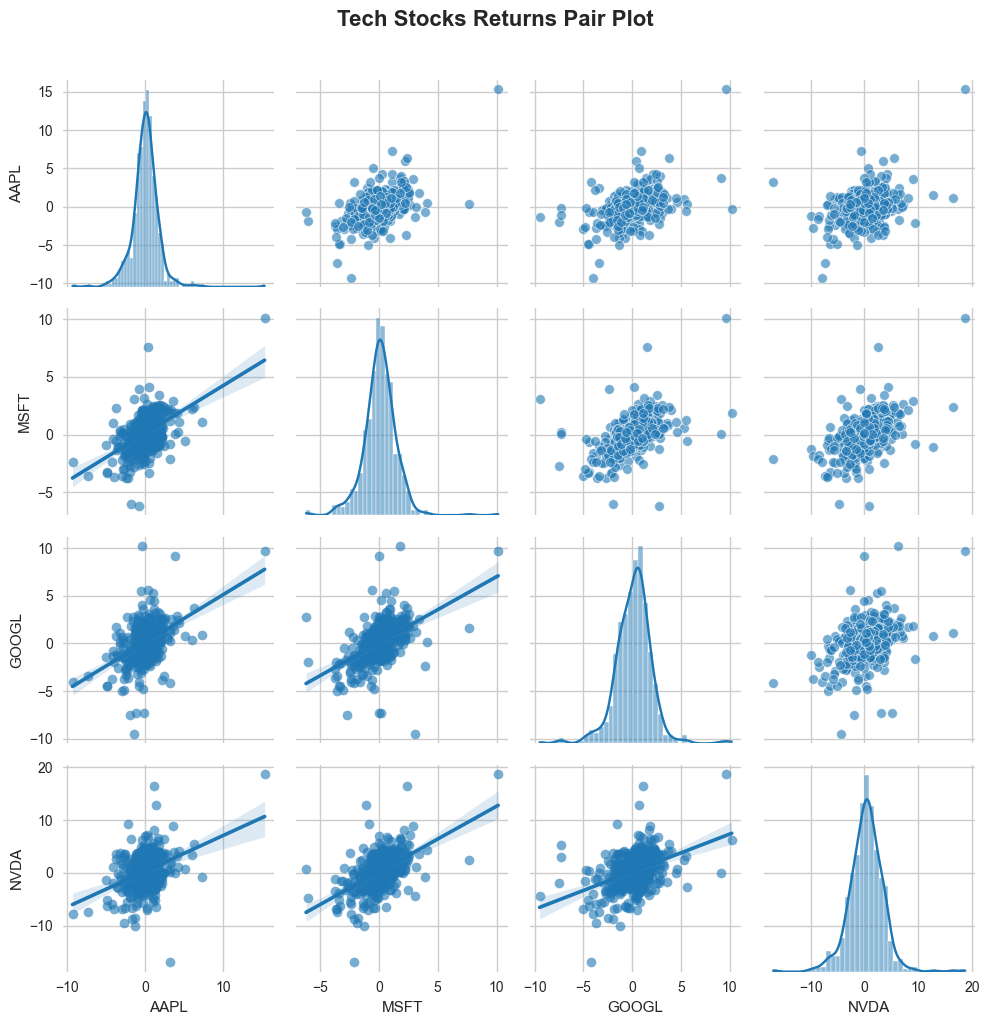

In [10]:
# Plot-4. Pair Plot for Tech Stocks
def create_tech_pairplot():
    tech_stocks = ['AAPL', 'MSFT', 'GOOGL', 'NVDA']     # Get tech stocks data
    tech_returns = {}
    
    for stock in tech_stocks:
        if stock in stock_data:
            tech_returns[stock] = stock_data[stock]['prices']['Returns'].dropna() * 100
    
    tech_df = pd.DataFrame(tech_returns)
    tech_df = tech_df.dropna()
    
    g = sns.PairGrid(tech_df, diag_sharey=False)        # Create pair plot
    g.map_upper(sns.scatterplot, alpha=0.6)
    g.map_lower(sns.regplot, scatter_kws={'alpha': 0.6})
    g.map_diag(sns.histplot, kde=True)
    
    g.fig.suptitle('Tech Stocks Returns Pair Plot', fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    viz_utils.save_plot(g.fig, 'seaborn_tech_pairplot.png')
    plt.show()

create_tech_pairplot()

Plot saved to static/images\seaborn_distribution_plots.png


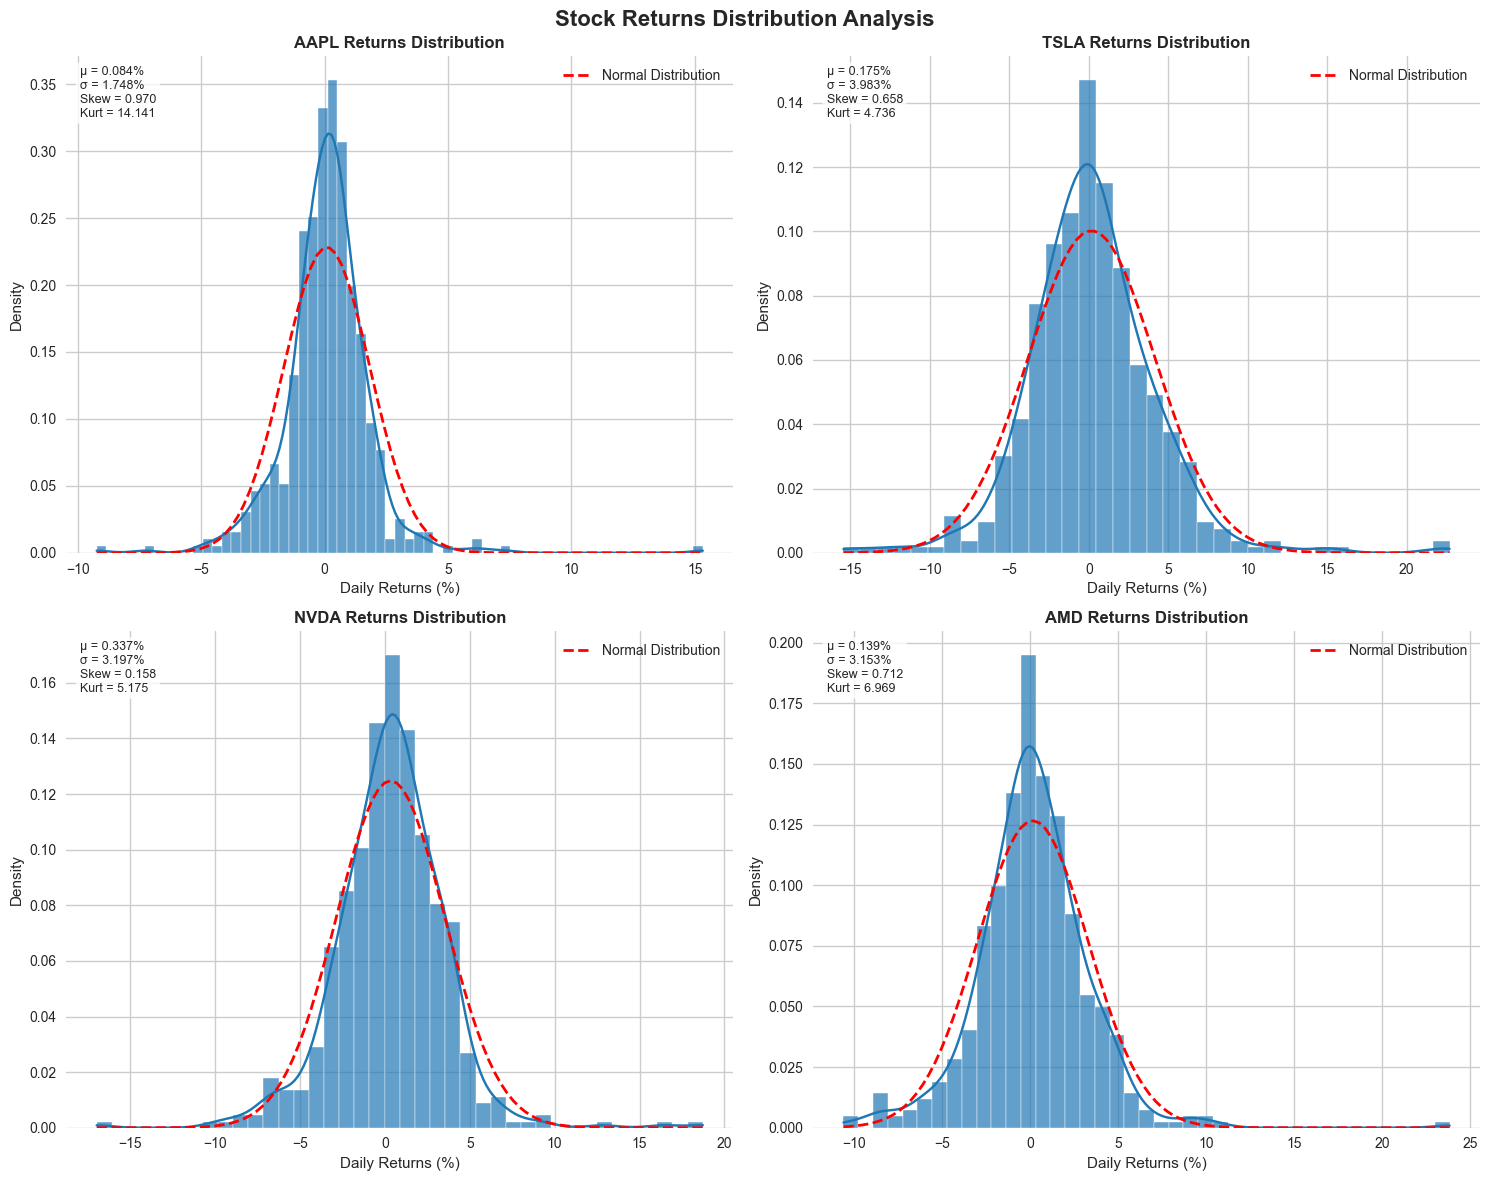

In [11]:
# Plot-5. Distribution Plots with KDE
def create_distribution_plots():
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Stock Returns Distribution Analysis', fontsize=16, fontweight='bold')
    
    stocks = ['AAPL', 'TSLA', 'NVDA', 'AMD']
    
    for idx, ticker in enumerate(stocks):
        row, col = idx // 2, idx % 2
        ax = axes[row, col]
        
        returns = stock_data[ticker]['prices']['Returns'].dropna() * 100
        
        sns.histplot(returns, kde=True, stat='density', alpha=0.7, ax=ax)       # Distribution plot with KDE
        
        mu, sigma = returns.mean(), returns.std()                   # Add normal distribution comparison
        x = np.linspace(returns.min(), returns.max(), 100)
        normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        ax.plot(x, normal_dist, 'r--', linewidth=2, label='Normal Distribution')
        
        ax.set_title(f'{ticker} Returns Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel('Daily Returns (%)')
        ax.set_ylabel('Density')
        ax.legend()
        
        stats_text = (f'μ = {mu:.3f}%\n'            # Add statistics
                     f'σ = {sigma:.3f}%\n'
                     f'Skew = {returns.skew():.3f}\n'
                     f'Kurt = {returns.kurtosis():.3f}')
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    viz_utils.save_plot(fig, 'seaborn_distribution_plots.png')
    plt.show()

create_distribution_plots()

Plot saved to static/images\seaborn_volatility_clustering_AAPL.png


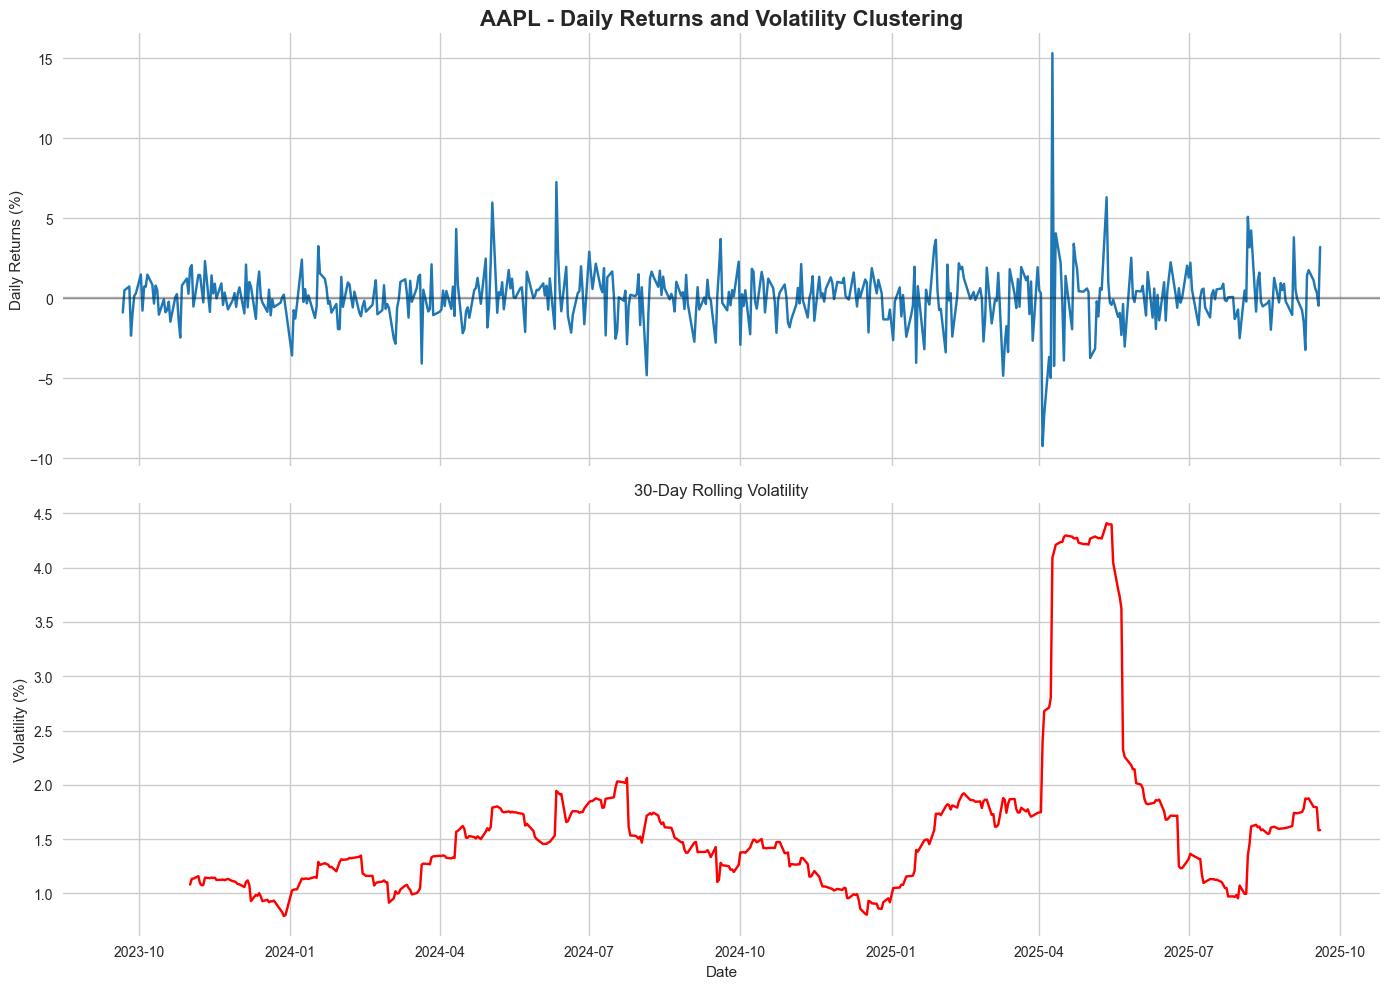

Seaborn statistical analysis complete!


In [12]:
# Plot-6: Volatility Clustering Visualization
def create_volatility_clustering():
    ticker = 'AAPL'
    prices = stock_data[ticker]['prices']
    returns = prices['Returns'].dropna() * 100
    rolling_vol = returns.rolling(window=30).std()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
    
    sns.lineplot(data=returns.reset_index(), x='Date', y='Returns', ax=ax1)     # Returns plot
    ax1.set_title(f'{ticker} - Daily Returns and Volatility Clustering', 
                  fontsize=16, fontweight='bold')
    ax1.set_ylabel('Daily Returns (%)')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    sns.lineplot(data=rolling_vol.reset_index(), x='Date', y='Returns',         # Rolling volatility plot
                 color='red', ax=ax2)
    ax2.set_title('30-Day Rolling Volatility')
    ax2.set_ylabel('Volatility (%)')
    ax2.set_xlabel('Date')
    
    plt.tight_layout()
    viz_utils.save_plot(fig, f'seaborn_volatility_clustering_{ticker}.png')
    plt.show()

create_volatility_clustering()

print("Seaborn statistical analysis complete!")